In [164]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from umap import UMAP
from sklearn.decomposition import PCA
from rdkit.Chem import MolFromSmiles, MolToSmiles
import numpy as np

# Max rows in pandas unlimited
pd.set_option('display.max_rows', None)

In [158]:
mean_df = pd.read_csv("mixture_rdkit_mean_definitions_clean.csv")
pna_df = pd.read_csv("mixture_rdkit_definitions_clean.csv")
mix_df = pd.read_csv("mixtures_combined.csv")
smi_df = pd.read_csv("mixture_smi_definitions_clean.csv")
smi_df['length'] = smi_df.apply(lambda row: len(row[2:].dropna()), axis=1)

# Figure 2

In [159]:
def get_umap(df, metric="cosine", title_name=""):
    umap_model = UMAP(metric = metric, densmap=True, random_state=42, low_memory = False)
    X_umap = umap_model.fit_transform(list(df[df.columns[3:]].values))
    df["UMAP_0"], df["UMAP_1"] = X_umap[:,0], X_umap[:,1]
    fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)
    g = sns.scatterplot(x="UMAP_0", y="UMAP_1", data=df, hue='length', palette='viridis', ax=ax, s=12, alpha=0.5)
    norm = plt.Normalize(df['length'].min(), df['length'].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Number of Components")
    ax.set_title(title_name)
    ax.get_legend().remove()
    return df

def get_pca(df, title_name=""):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(list(df[df.columns[3:]].values))
    df["PCA_0"], df["PCA_1"] = X_pca[:,0], X_pca[:,1]
    fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)
    g = sns.scatterplot(x="PCA_0", y="PCA_1", data=df, ax=ax, hue='length', palette='viridis', s=12, alpha=0.5)
    norm = plt.Normalize(df['length'].min(), df['length'].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Number of Components")
    ax.set_xlabel(f"PC0 ({pca.explained_variance_ratio_[0]*100:.01f}%)")
    ax.set_ylabel(f"PC1 ({pca.explained_variance_ratio_[1]*100:.01f}%)")
    ax.set_title(title_name)
    ax.get_legend().remove()
    return df



In [ ]:
mean_df = pd.merge(smi_df[['Dataset', 'Mixture Label', 'length']], mean_df, on=["Dataset", "Mixture Label"], how='left')
mean_umap_df = get_umap(mean_df, title_name="UMAP RDKit Mean Aggregation")
mean_pca_df = get_pca(mean_df, title_name="PCA RDKit Mean Aggregation")

pna_df = pd.merge(smi_df[['Dataset', 'Mixture Label', 'length']], pna_df, on=["Dataset", "Mixture Label"], how='left')
pna_umap_df = get_umap(pna_df, title_name="UMAP RDKit PNA")
pna_pca_df = get_pca(pna_df, title_name="PCA RDKit PNA")

In [ ]:
pna_umap_df[(pna_umap_df['UMAP_0'] < 15) & (pna_umap_df['UMAP_1'] >= 5)]

In [ ]:
# Define mix1 as each row's Dataset and Mixture 1 value, and mix2 as Dataset and Mixture 2 value
# Get pna_df.columns[2:] for mix1 and mix2, and calculate the cosine distance between them

def get_aggregate(dataset, mixture_id, df):
    return df[(df["Dataset"] == dataset) & (df["Mixture Label"] == mixture_id)].iloc[0, 2:].to_numpy(dtype="float32")

def get_distance(dataset, mixture1, mixture2, df, distance='cosine'):
    mix1 = get_aggregate(dataset, mixture1, df)
    mix2 = get_aggregate(dataset, mixture2, df)
    return pdist([mix1, mix2], metric=distance)[0]

In [44]:
mix_df["Mean Cosine Distance"] = mix_df.apply(lambda row: get_distance(row["Dataset"], row["Mixture 1"], row["Mixture 2"], mean_df), axis=1)
mix_df["PNA Cosine Distance"] = mix_df.apply(lambda row: get_distance(row["Dataset"], row["Mixture 1"], row["Mixture 2"], pna_df), axis=1)

Text(0, 0.5, 'Perceptual Similarity')

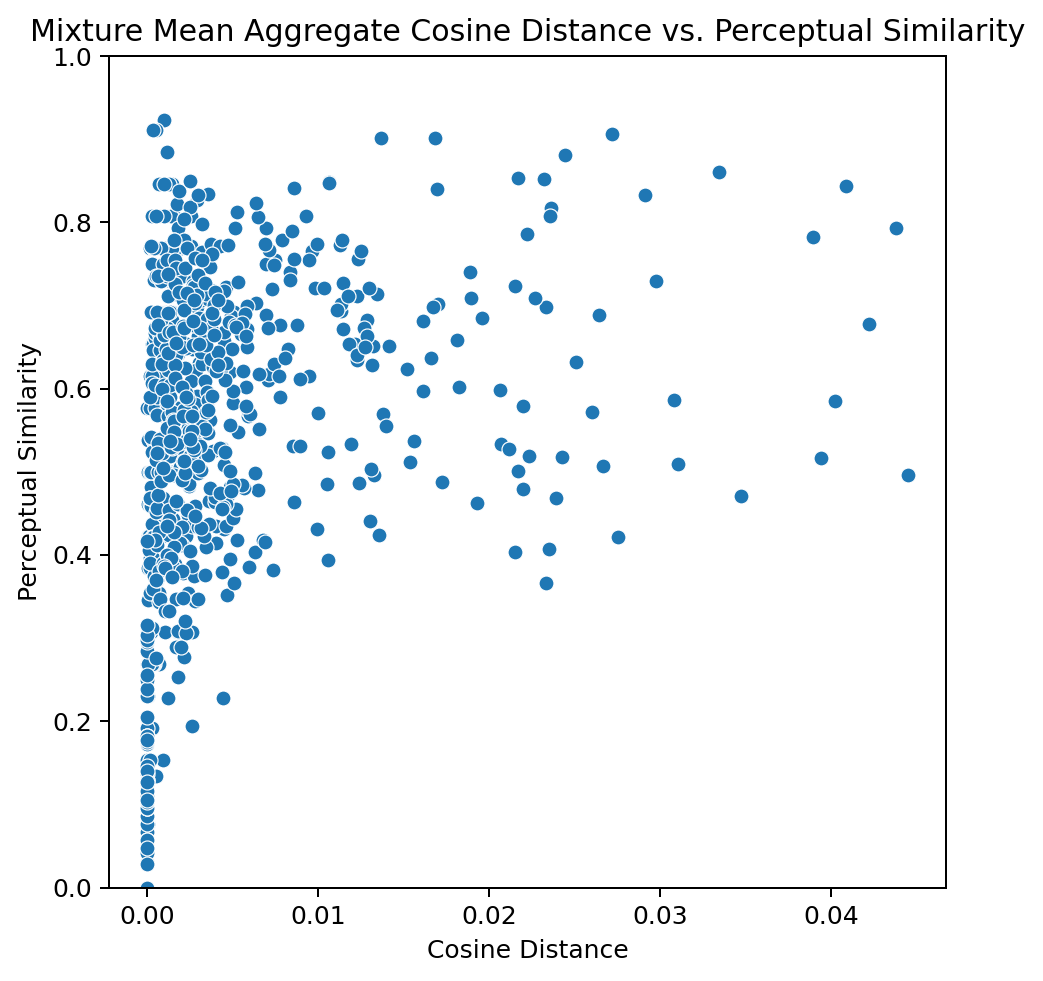

In [47]:
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)

g = sns.scatterplot(x="Mean Cosine Distance", y='Experimental Values', data=mix_df, ax=ax)

ax.set_ylim([0, 1])
ax.set_title("Mixture Mean Aggregate Cosine Distance vs. Perceptual Similarity")
ax.set_xlabel("Cosine Distance")
ax.set_ylabel("Perceptual Similarity")

Text(0, 0.5, 'Perceptual Similarity')

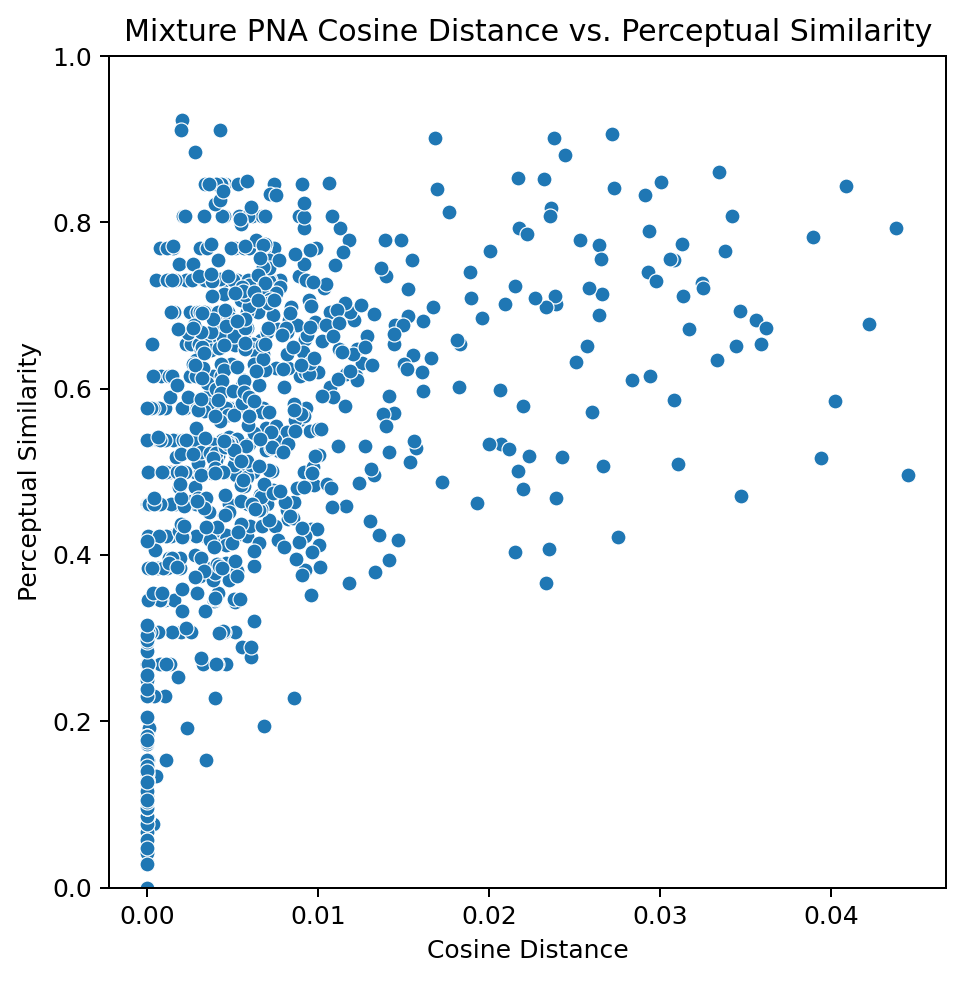

In [48]:
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)

g = sns.scatterplot(x="PNA Cosine Distance", y='Experimental Values', data=mix_df, ax=ax)

ax.set_ylim([0, 1])
ax.set_title("Mixture PNA Cosine Distance vs. Perceptual Similarity")
ax.set_xlabel("Cosine Distance")
ax.set_ylabel("Perceptual Similarity")